共线性问题指的是输入的自变量之间存在较高的线性相关度。共线性问题会导致回归模型的稳定性和准确性大大降低，另外，过多无关的维度计算也很浪费时间

常见的共线性业务场景，明显的共线性的维度或变量包括：
+ 访问量和页面浏览量
+ 页面浏览量和访问时间
+ 订单量和销售额
+ 订单量和转化率
+ 促销费用和销售额
+ 网络展示广告费用和访客数

变量出现共线性的原因：
+ 数据样本不够，导致共线性存在偶然性，这其实反映了缺少数据对于数据建模的影响，共线性仅仅是影响的一部分
+ 多个变量都给予时间有共同或相反的演变趋势，例如春节期间的网络销售量和销售额都相对与正常时间有下降趋势。
+ 多个变量存在一定的推移关系，但总体上变量间的趋势一致，只是发生的时间点不一致，例如广告费用和销售额之间，通常是品牌广告先进行大范围的曝光和信息推送，经过一定时间传播之后，才会在销售额上做出反映。
+ 多变量之间存在线性的关系。例如y代表访客数，用x代表展示广告费用，那么二者的关系很可能是y=2*x + b 



如何检验共线性：
+ 容忍度（Tolerance）：容忍度是每个自变量作为因变量对其他自变量进行回归建模时得到的残差比例，大小用1减得到的决定系数来表示。容忍度值越小说明这个自变量与其他自变量间越可能存在共线性问题。
+ 方差膨胀因子 VIF是容忍度的倒数，值越大则共线性问题越明显，通常以10作为判断边界。当VIF<10,不存在多重共线性；当10<=VIF<100,存在较强的多重共线性；当VIF>=100, 存在严重多重共线性。
+ 特征值（Eigenvalue）：该方法实际上就是对自变量做主成分分析，如果多个维度的特征值等于0，则可能有比较严重的共线性。
+ 相关系数：如果相关系数R>0.8时就可能存在较强相关性

处理共线性：
+ 增大样本量：增大样本量可以消除犹豫数据量不足而出现的偶然的共线性现象，在可行的前提下这种方法是需要优先考虑的
+ 岭回归法（Ridge Regression）：实际上是一种改良最小二乘估计法。通过放弃最小二乘法的无偏性，以损失部分信息、降低精度为代价来获得更实际和可靠性更强的回归系数。因此岭回归在存在较强共线性的回归应用中较为常用。
+ 逐步回归法（Stepwise Regression）:每次引入一个自变量进行统计检验，然后逐步引入其他变量，同时对所有变量的回归系数进行检验，如果原来引入的变量由于后面变量的引入而变得不再显著，那么久将其剔除，逐步得到最有回归方程。
+ 主成分回归（Principal Components Regression）:通过主成分分析，将原始参与建模的变量转换为少数几个主成分，么个主成分是原变量的线性组合，然后基于主成分做回归分析，这样也可以在不丢失重要数据特征的前提下避开共线性问题。
+ 人工去除：结合人工经验，对自变量进行删减，但是对操作者的业务能力、经验有很高的要求。

In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import Ridge
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/ffzs/dataset/master/boston/train.csv')

In [3]:
df.head()

,ID,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
0,1,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,2,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,4,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
3,5,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2
4,7,0.08829,12.5,7.87,0,0.524,6.012,66.6,5.5605,5,311,15.2,395.60,12.43,22.9


In [4]:
# 切分自变量
X = df.iloc[:, 1:-1].values

# 切分预测变量
y = df.iloc[:, [-1]].values

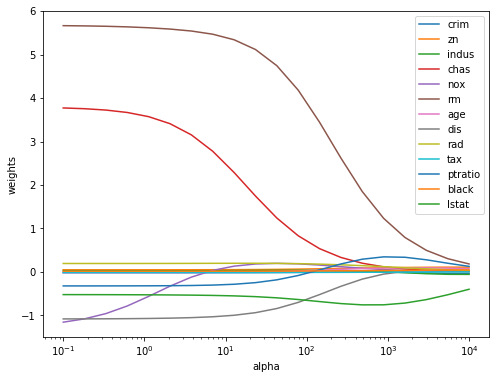

In [26]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,6))
n_alphas = 20
alphas = np.logspace(-1,4,num=n_alphas)
coefs = []
for a in alphas:
    ridge = Ridge(alpha=a, fit_intercept=False)
    ridge.fit(X, y)
    coefs.append(ridge.coef_[0])
ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale('log')
handles, labels = ax.get_legend_handles_labels()
plt.legend(labels=df.columns[1:-1])
plt.xlabel('alpha')
plt.ylabel('weights')
plt.axis('tight')
plt.savefig('a.png')
plt.show()


In [18]:
# 主成分回归进行回归分析
pca_model = PCA()
data_pca = pca_model.fit_transform(X)

In [24]:
# 得到所有主成分方差
ratio_cumsum = np.cumsum(pca_model.explained_variance_ratio_)
# 获取方差占比超过0.8的索引值
rule_index = np.where(ratio_cumsum > 0.9)
# 获取最小的索引值
min_index = rule_index[0][0]
# 根据最小索引值提取主成分
data_pca_result = data_pca[:, :min_index+1]
# 建立回归模型
model_liner = LinearRegression()
# 训练模型
model_liner.fit(data_pca_result, y)
print(model_liner.coef_)

[[-0.02430516 -0.01404814]]
